In [1]:
import sys ###amdp_policy_agent
sys.path.append('../scripts/')
from dp_policy_agent import *

In [2]:
class AmdpPolicyAgent(DpPolicyAgent): 
    def __init__(self, time_interval, estimator, goal, puddle_coef=100, widths=np.array([0.2, 0.2, math.pi/18]).T, \
                 lowerleft=np.array([-4, -4]).T, upperright=np.array([4, 4]).T, dev_borders=[0.1,0.2,0.4,0.8]):
        super().__init__(time_interval, estimator, goal, puddle_coef, widths, lowerleft, upperright) 
        
        self.index_nums = np.array([*self.index_nums, len(dev_borders) + 1]) #BeliefDynamicProgrammingから持ってくる
        self.dev_borders = dev_borders
        self.policy_data = self.init_belief_policy(self.index_nums)
        
    def init_belief_policy(self, index_nums): #ファイルの読み込み（1次元増える）
        tmp = np.zeros(np.r_[index_nums,2])
        for line in open("policy_amdp.txt", "r"):
            d = line.split()
            tmp[int(d[0]), int(d[1]), int(d[2]), int(d[3])] = [float(d[4]), float(d[5])]
            
        return tmp
    
    def cov_to_index(self, cov): #BeliefDynamicProgrammingから持ってくる
        sigma = np.power(np.linalg.det(cov), 1.0/6)
        for i, e in enumerate(self.dev_borders):
            if sigma < e: return i
            
        return len(self.dev_borders)
    
    def policy(self, pose, goal=None): #姿勢から離散状態のインデックスを作って方策を参照して返すだけ
        pose_index = self.to_index(self.estimator.belief.mean, self.pose_min, self.index_nums[0:3], self.widths)
        belief_index = self.cov_to_index(self.estimator.belief.cov)
        a = self.policy_data[(*pose_index, belief_index)]
        
        if tuple(a) == (0.0, 0.0): #ゴールしていないのに止まったら前進させるヒューリスティック
            a = [1.0, 0.0]
        
        return a

<IPython.core.display.Javascript object>


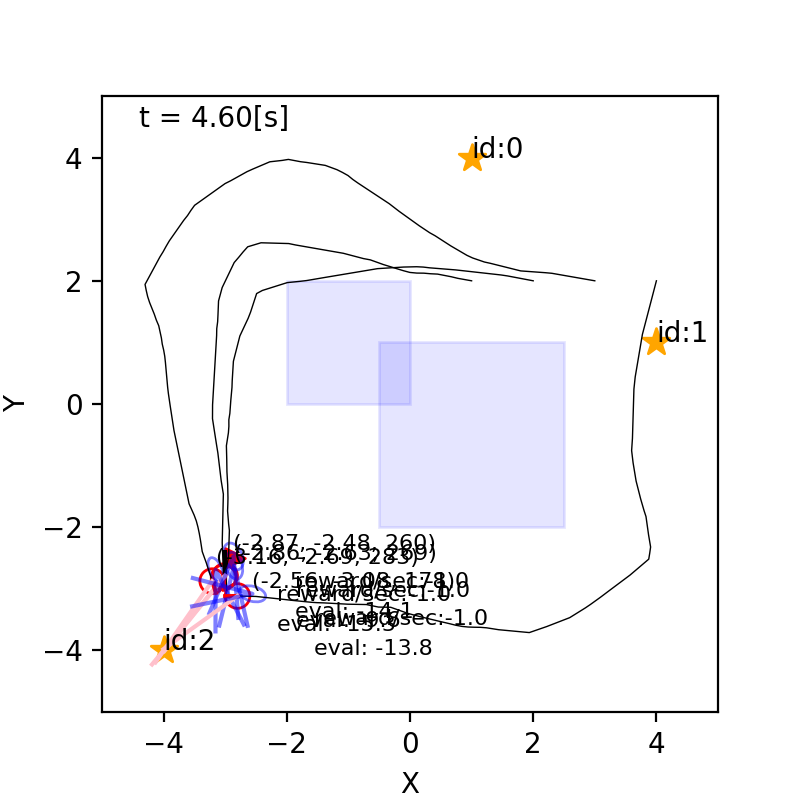

In [13]:
def trial(animation):  ###dppolicyagentrun
    time_interval = 0.1
    world = PuddleWorld(15, time_interval, debug= not animation)
    ## 地図を生成して3つランドマークを追加 ##
    m = Map()
    for ln in [(1,4), (4,1), (-4,-4)]: m.append_landmark(Landmark(*ln))
    world.append(m)   

    ##ゴールの追加##
    goal = Goal(-3,-3)  #goalを変数に
    world.append(goal)
    
    ##水たまりの追加##
    world.append(Puddle((-2, 0), (0, 2), 0.1)) 
    world.append(Puddle((-0.5, -2), (2.5, 1), 0.1)) 

    ##4台のロボットを動かしてみる##   ##dppolicyagentrun
    init_poses = []
    for p in [[1, 2, np.pi], [2, 2, np.pi], [3, 2, np.pi], [4, 2, np.pi]]:
#    for p in [[-3, 4, np.pi], [0.5, 1.5, np.pi], [3, 3, np.pi], [2, -1, np.pi]]:
#    for p in [[2.5, 2.5, 0]]:
        init_pose = np.array(p).T
        
    
        kf = KalmanFilter(m, init_pose)
    #    a = DpPolicyAgent(time_interval, kf, goal)
        a = AmdpPolicyAgent(time_interval, kf, goal)
        r = Robot(init_pose, sensor=Camera(m), agent=a, color="red")

        world.append(r)
        
    world.draw()
    world.ani.save('/tmp/anm.gif', writer='imagemagick', fps=10)
    return a
    
a = trial(True)

<IPython.core.display.Javascript object>


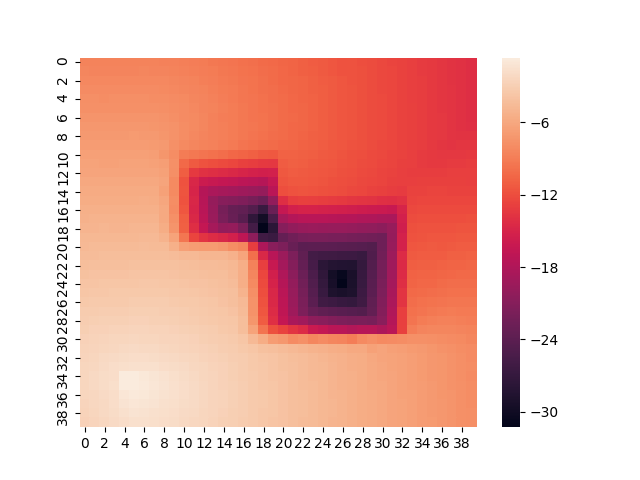

In [4]:
index_nums = np.array([40, 40, 36, 5])
nx, ny, nt, nh = index_nums
indexes = list(itertools.product(range(nx), range(ny), range(nt), range(nh)))

vs = np.empty(index_nums)
        
for line in open("value_amdp.txt", "r"):
    d = line.split()
    vs[int(d[0]), int(d[1]), int(d[2]), int(d[3])] = float(d[4])
    
import seaborn as sns
v = vs[:, :, 9, 1]
sns.heatmap(np.rot90(v), square=False)
plt.show()

In [5]:
def evaluation():
    with open("amdp_result.txt", "w") as f:
        num = 1000
        for i in range(num):
            a = trial(False)
            f.write("{} {}\n".format(a.total_reward+a.final_value, a.in_goal))
            f.flush()

In [6]:
#evaluation()